In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os

In [2]:
import peakutils

In [3]:
NUMBER_OF_RUNS_IN_EXPERIMENT = 20

In [4]:
percolator_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/percolator_df.pkl')

In [7]:
percolator_df.columns

Index(['file_idx', 'scan', 'charge_x', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa', 'feature_id', 'charge_y',
       'rt_apex', 'rt_peak_width', 'scan_apex', 'scan_peak_width', 'intensity',
       'precursor_id', 'monoisotopic_mass', 'predicted_mass_error',
       'recalibrated_monoisotopic_mass', 'recalibrated_monoisotopic_mz',
       'percolator_idx', 'batch', 'human'],
      dtype='object')

In [11]:
# find the experiment-average for each sequence-charge identified
experiment_sequences_l = []
for group_name,group_df in percolator_df.groupby(['sequence','charge_x'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    theoretical_mz = group_df.iloc[0]['spectrum precursor m/z']
    experiment_scan = peakutils.centroid(group_df.scan_apex, group_df.intensity)
    experiment_scan_peak_width = group_df.scan_peak_width.mean()
    experiment_rt = peakutils.centroid(group_df.rt_apex, group_df.intensity)
    experiment_rt_peak_width = group_df.rt_peak_width.mean()
    experiment_intensity = group_df.intensity.mean()
    experiment_sequences_l.append((sequence, charge, theoretical_mz, experiment_scan, experiment_scan_peak_width, experiment_rt, experiment_rt_peak_width, experiment_intensity))
    

In [12]:
experiment_sequences_df = pd.DataFrame(experiment_sequences_l, columns=['sequence','charge','theoretical_mz', 'experiment_scan', 'experiment_scan_peak_width', 'experiment_rt', 'experiment_rt_peak_width', 'experiment_intensity'])


In [13]:
experiment_sequences_df.head()

,sequence,charge,theoretical_mz,experiment_scan,experiment_scan_peak_width,experiment_rt,experiment_rt_peak_width,experiment_intensity
0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.1049,73.911301,57.626667,602.012681,18.706667,108754.444444
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,789.7394,335.868469,56.366667,609.864140,5.030000,29377.333333
2,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.0286,160.291329,64.555556,489.973155,6.357111,58456.622222
3,AAAAALSQQQSLQER,2,785.9075,496.361511,45.912500,375.039574,6.140000,57092.250000
4,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,864.1171,707.537580,48.382593,1039.861047,16.666296,50988.518519


In [14]:
experiment_sequences_df.to_pickle('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/training-sets/experiment-sequence-charge-attribs-df.pkl')

In [15]:
# for each run, find the mz, scan, RT, and intensity for each sequence-charge identified
run_sequences_l = []
for group_name,group_df in percolator_df.groupby(['file_idx','sequence','charge_x'], as_index=False):
    file_idx = group_name[0]
    sequence = group_name[1]
    charge = group_name[2]
    run_mz = peakutils.centroid(group_df.recalibrated_monoisotopic_mz, group_df.intensity)
    run_mz_std_dev = np.std(group_df.recalibrated_monoisotopic_mz)
    run_scan = peakutils.centroid(group_df.scan_apex, group_df.intensity)
    run_scan_std_dev = np.std(group_df.scan_apex)
    run_rt = peakutils.centroid(group_df.rt_apex, group_df.intensity)
    run_rt_std_dev = np.std(group_df.rt_apex)
    run_intensity = np.mean(group_df.intensity)
    run_intensity_std_dev = np.std(group_df.intensity)
    run_sequences_l.append((file_idx,sequence,charge,run_mz,run_scan,run_rt,run_mz_std_dev,run_scan_std_dev,run_rt_std_dev,run_intensity,run_intensity_std_dev))

In [16]:
run_sequences_df = pd.DataFrame(run_sequences_l, columns=['file_idx','sequence','charge','run_mz','run_scan','run_rt','run_mz_std_dev','run_scan_std_dev','run_rt_std_dev','run_intensity','run_intensity_std_dev'])


In [17]:
run_sequences_df.head()

,file_idx,sequence,charge,run_mz,run_scan,run_rt,run_mz_std_dev,run_scan_std_dev,run_rt_std_dev,run_intensity,run_intensity_std_dev
0,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608297,74.065131,601.582008,0.000006,0.465000,0.065000,146908.000000,15838.0000
1,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532238,156.625361,486.692475,0.000094,2.523085,0.028284,53127.666667,4860.1922
2,0,AAAAAWEEPSSGNGTAR,2,823.382023,535.310000,367.240000,0.000000,0.000000,0.000000,258410.000000,0.0000
3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,892.112877,468.100000,997.180000,0.000000,0.000000,0.000000,203979.000000,0.0000
4,0,AAAEDVNVTFEDQQK,2,832.891870,485.630000,471.790000,0.000000,0.000000,0.000000,74963.000000,0.0000


In [18]:
import matplotlib.pyplot as plt

In [19]:
run_sequences_df['cv_mz'] = run_sequences_df.run_mz_std_dev / run_sequences_df.run_mz
run_sequences_df['cv_scan'] = run_sequences_df.run_scan_std_dev / run_sequences_df.run_scan
run_sequences_df['cv_rt'] = run_sequences_df.run_rt_std_dev / run_sequences_df.run_rt
run_sequences_df['cv_intensity'] = run_sequences_df.run_intensity_std_dev / run_sequences_df.run_intensity

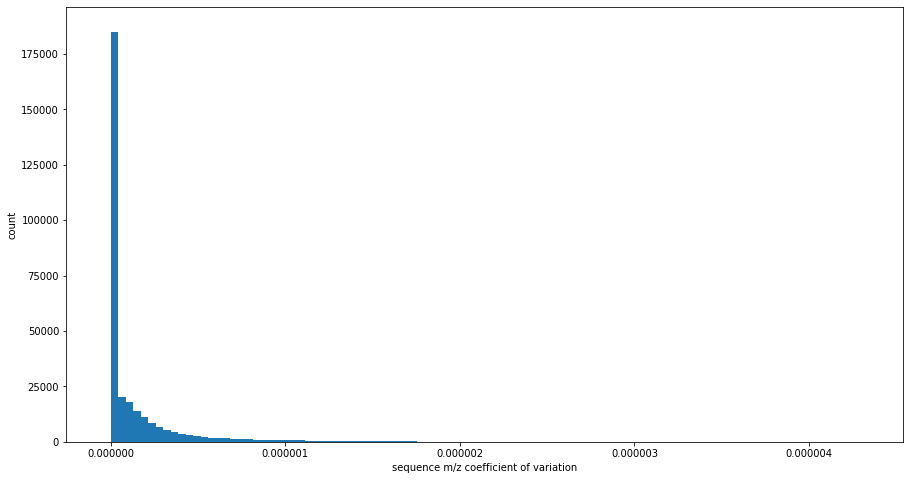

In [20]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(run_sequences_df.cv_mz, bins=bins)
plt.xlabel('sequence m/z coefficient of variation')
plt.ylabel('count')

plt.show()

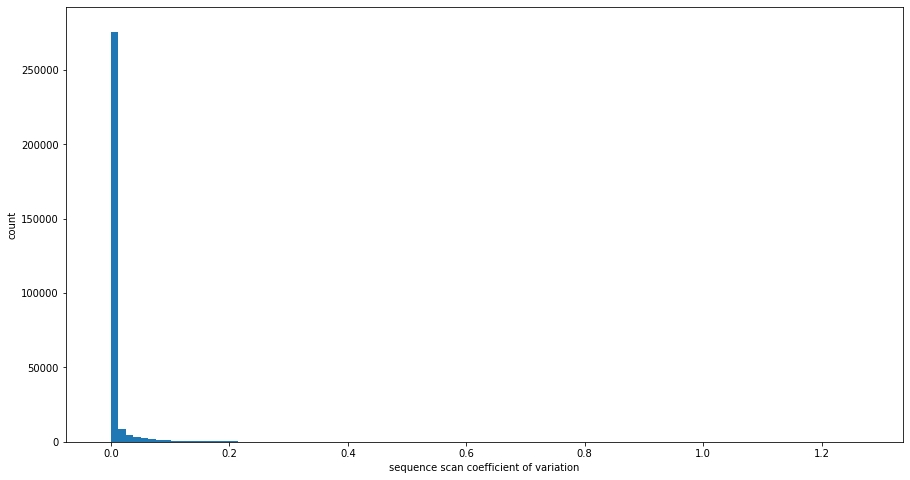

In [21]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(run_sequences_df.cv_scan, bins=bins)
plt.xlabel('sequence scan coefficient of variation')
plt.ylabel('count')

plt.show()

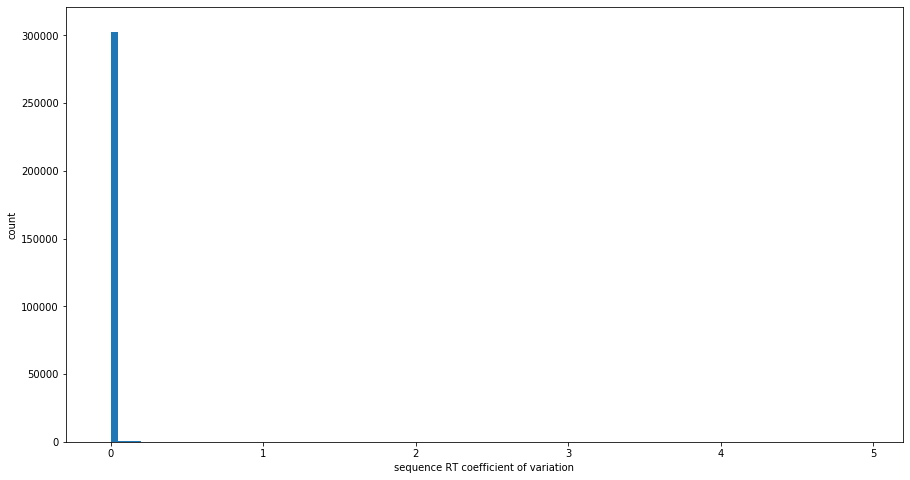

In [22]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(run_sequences_df.cv_rt, bins=bins, label='m/z delta')
plt.xlabel('sequence RT coefficient of variation')
plt.ylabel('count')

plt.show()

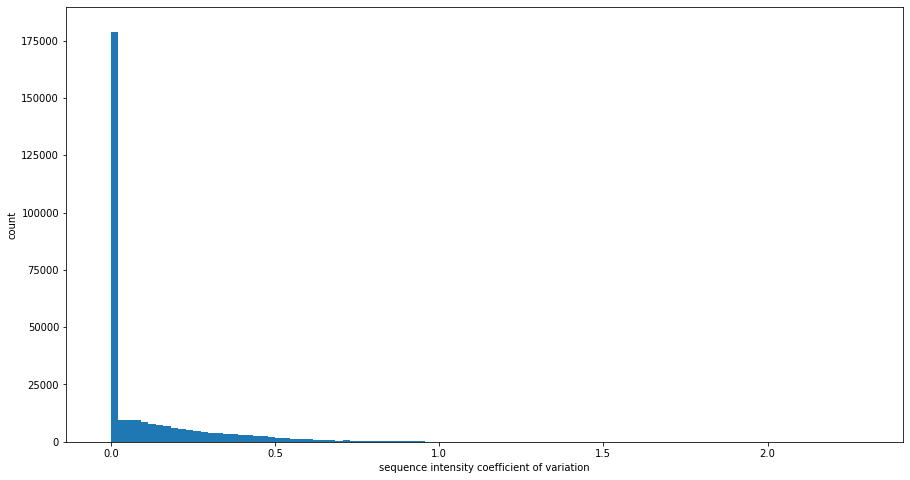

In [23]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(run_sequences_df.cv_intensity, bins=bins)
plt.xlabel('sequence intensity coefficient of variation')
plt.ylabel('count')

plt.show()

In [24]:
# merge the sequence-charges for each run with their experiment-wide averages
merged_df = pd.merge(run_sequences_df, experiment_sequences_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])

In [25]:
# for each run-sequence-charge, calculate the delta from the experiment-wide average
merged_df['delta_mz'] = merged_df.theoretical_mz - merged_df.run_mz
merged_df['delta_scan'] = merged_df.experiment_scan - merged_df.run_scan
merged_df['delta_rt'] = merged_df.experiment_rt - merged_df.run_rt

In [26]:
merged_df.head()

,file_idx,sequence,charge,run_mz,run_scan,run_rt,run_mz_std_dev,run_scan_std_dev,run_rt_std_dev,run_intensity,...,cv_intensity,theoretical_mz,experiment_scan,experiment_scan_peak_width,experiment_rt,experiment_rt_peak_width,experiment_intensity,delta_mz,delta_scan,delta_rt
0,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608297,74.065131,601.582008,0.000006,0.465000,0.065000,146908.000000,...,0.107809,1184.1049,73.911301,57.626667,602.012681,18.706667,108754.444444,-0.503397,-0.153831,0.430673
1,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532238,156.625361,486.692475,0.000094,2.523085,0.028284,53127.666667,...,0.091481,1016.0286,160.291329,64.555556,489.973155,6.357111,58456.622222,-0.503638,3.665967,3.280680
2,0,AAAAAWEEPSSGNGTAR,2,823.382023,535.310000,367.240000,0.000000,0.000000,0.000000,258410.000000,...,0.000000,822.8783,533.861853,53.898095,371.271659,6.114524,277023.690476,-0.503723,-1.448147,4.031659
3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,892.112877,468.100000,997.180000,0.000000,0.000000,0.000000,203979.000000,...,0.000000,891.7775,465.668232,115.010000,997.391366,6.381000,150202.950000,-0.335377,-2.431768,0.211366
4,0,AAAEDVNVTFEDQQK,2,832.891870,485.630000,471.790000,0.000000,0.000000,0.000000,74963.000000,...,0.000000,832.3878,487.082550,43.335455,475.841292,8.563636,116982.693430,-0.504070,1.452550,4.051292


In [27]:
merged_df.drop(['run_mz_std_dev','run_scan_std_dev','run_rt_std_dev','run_intensity_std_dev'], axis=1, inplace=True)

In [28]:
merged_df.to_pickle('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/training-sets/file-sequence-charge-attribs-df.pkl')